_Alex Malz (NYU)_

_(Add your name here when contributing.)_

# Hack 'de Blend

This notebook outlines an approach to studying the systematics of Erin Sheldon's MOF pipeline due to blending as a function of (1) nearest neighbor distance and (2) nearest neighbor flux/magnitude.

_This would be easier if we could run this notebook on NERSC, but I don't know how to do that._

## Data

The data lives [on NERSC](/global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/) and includes the following information in 5 150 GB `FITS` tables:

__HDU 0__:

SIMPLE  =                    T / file does conform to FITS standard

BITPIX  =                   16 / number of bits per data pixel

NAXIS   =                    0 / number of data axes

EXTEND  =                    T / FITS dataset may contain extensions

COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy

COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H

__HDU 1__:

XTENSION= 'BINTABLE'           / binary table extension

BITPIX  =                    8 / 8-bit bytes

NAXIS   =                    2 / 2-dimensional binary table

NAXIS1  =                 3040 / width of table in bytes

NAXIS2  =             52433036 / number of rows in table

PCOUNT  =                    0 / size of special data area

GCOUNT  =                    1 / one data group (required keyword)

TFIELDS =                   80 / number of fields in each row

TTYPE1  = 'id      '           / label for field   1

<TFORM1  = 'K       '           / data format of field: 8-byte INTEGER>

TTYPE2  = 'number  '           / label for field   2

<TFORM2  = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE3  = 'ra      '           / label for field   3

<TFORM3  = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE4  = 'dec     '           / label for field   4

<TFORM4  = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE5  = 'nimage_tot'         / label for field   5

<TFORM5  = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE6  = 'fofid   '           / label for field   6

<TFORM6  = 'K       '           / data format of field: 8-byte INTEGER>

TTYPE7  = 'flags   '           / label for field   7

<TFORM7  = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE8  = 'time_last_fit'      / label for field   8

<TFORM8  = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE9  = 'box_size'           / label for field   9

<TFORM9  = 'I       '           / data format of field: 2-byte INTEGER>

TTYPE10 = 'obj_flags'          / label for field  10

<TFORM10 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE11 = 'psf_flags'          / label for field  11

<TFORM11 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE12 = 'psf_flux'           / label for field  12

<TFORM12 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE13 = 'psf_flux_err'       / label for field  13

<TFORM13 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE14 = 'psf_flux_s2n'       / label for field  14

<TFORM14 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE15 = 'nimage_use'         / label for field  15

<TFORM15 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE16 = 'mask_frac'          / label for field  16

<TFORM16 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE17 = 'psfrec_T'           / label for field  17

<TFORM17 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE18 = 'psfrec_g'           / label for field  18

<TFORM18 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE19 = 'gauss_flags'        / label for field  19

<TFORM19 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE20 = 'gauss_pars'         / label for field  20

<TFORM20 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE21 = 'gauss_pars_cov'     / label for field  21

<TFORM21 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE22 = 'gauss_g '           / label for field  22

<TFORM22 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE23 = 'gauss_g_cov'        / label for field  23

<TFORM23 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE24 = 'gauss_max_flags'    / label for field  24

<TFORM24 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE25 = 'gauss_max_pars'     / label for field  25

<TFORM25 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE26 = 'gauss_max_pars_cov' / label for field  26

<TFORM26 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE27 = 'gauss_s2n_w'        / label for field  27

<TFORM27 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE28 = 'gauss_chi2per'      / label for field  28

<TFORM28 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE29 = 'gauss_dof'          / label for field  29

<TFORM29 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE30 = 'gauss_flags_r'      / label for field  30

<TFORM30 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE31 = 'gauss_s2n_r'        / label for field  31

<TFORM31 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE32 = 'gauss_T_r'          / label for field  32

<TFORM32 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE33 = 'gauss_psf_T_r'      / label for field  33

<TFORM33 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE34 = 'mcal_flags'         / label for field  34

<TFORM34 = 'K       '           / data format of field: 8-byte INTEGER>

TTYPE35 = 'mcal_g  '           / label for field  35

<TFORM35 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE36 = 'mcal_g_cov'         / label for field  36

<TFORM36 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE37 = 'mcal_pars'          / label for field  37

<TFORM37 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE38 = 'mcal_pars_cov'      / label for field  38

<TFORM38 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE39 = 'mcal_gpsf'          / label for field  39

<TFORM39 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE40 = 'mcal_Tpsf'          / label for field  40

<TFORM40 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE41 = 'mcal_T  '           / label for field  41

<TFORM41 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE42 = 'mcal_T_err'         / label for field  42

<TFORM42 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE43 = 'mcal_T_r'           / label for field  43

<TFORM43 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE44 = 'mcal_s2n_r'         / label for field  44

<TFORM44 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE45 = 'mcal_g_1p'          / label for field  45

<TFORM45 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE46 = 'mcal_g_cov_1p'      / label for field  46

<TFORM46 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE47 = 'mcal_pars_1p'       / label for field  47

<TFORM47 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE48 = 'mcal_pars_cov_1p'   / label for field  48

<TFORM48 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE49 = 'mcal_T_1p'          / label for field  49

<TFORM49 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE50 = 'mcal_T_err_1p'      / label for field  50

<TFORM50 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE51 = 'mcal_T_r_1p'        / label for field  51

<TFORM51 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE52 = 'mcal_s2n_r_1p'      / label for field  52

<TFORM52 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE53 = 'mcal_g_1m'          / label for field  53

<TFORM53 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE54 = 'mcal_g_cov_1m'      / label for field  54

<TFORM54 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE55 = 'mcal_pars_1m'       / label for field  55

<TFORM55 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE56 = 'mcal_pars_cov_1m'   / label for field  56

<TFORM56 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE57 = 'mcal_T_1m'          / label for field  57

<TFORM57 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE58 = 'mcal_T_err_1m'      / label for field  58

<TFORM58 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE59 = 'mcal_T_r_1m'        / label for field  59

<TFORM59 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE60 = 'mcal_s2n_r_1m'      / label for field  60

<TFORM60 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE61 = 'mcal_g_2p'          / label for field  61

<TFORM61 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE62 = 'mcal_g_cov_2p'      / label for field  62

<TFORM62 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE63 = 'mcal_pars_2p'       / label for field  63

<TFORM63 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE64 = 'mcal_pars_cov_2p'   / label for field  64

<TFORM64 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE65 = 'mcal_T_2p'          / label for field  65

<TFORM65 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE66 = 'mcal_T_err_2p'      / label for field  66

<TFORM66 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE67 = 'mcal_T_r_2p'        / label for field  67

<TFORM67 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE68 = 'mcal_s2n_r_2p'      / label for field  68

<TFORM68 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE69 = 'mcal_g_2m'          / label for field  69

<TFORM69 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE70 = 'mcal_g_cov_2m'      / label for field  70

<TFORM70 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE71 = 'mcal_pars_2m'       / label for field  71

<TFORM71 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE72 = 'mcal_pars_cov_2m'   / label for field  72

<TFORM72 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE73 = 'mcal_T_2m'          / label for field  73

<TFORM73 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE74 = 'mcal_T_err_2m'      / label for field  74

<TFORM74 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE75 = 'mcal_T_r_2m'        / label for field  75

<TFORM75 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE76 = 'mcal_s2n_r_2m'      / label for field  76

<TFORM76 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE77 = 'sxflags '           / label for field  77

<TFORM77 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE78 = 'shear_true'         / label for field  78

<TFORM78 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE79 = 'shear_index'        / label for field  79

<TFORM79 = 'I       '           / data format of field: 2-byte INTEGER>

TTYPE80 = 'file_id '           / label for field  80

<TFORM80 = 'J       '           / data format of field: 4-byte INTEGER>

_To start, I don't know what many of these columns mean!_

In [3]:
import fitsio
import numpy as np
import glob
import os
data_dir = '/global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/'
filename = glob.glob(os.path.join(data_dir,'*.fits'))
file_id = fitsio.read(str(filename[0]), columns='file_id')
uids = np.unique(file_id)
for uid in uids:
    w, = np.where(file_id == uid)
    data = fitsio.read(filename[0], rows=w)

In [12]:
print(filename[0])

/global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/run-003b-max001.fits


In [15]:
data['ra']

array([ 289.38328095,  289.35200274,  289.42632974, ...,  289.48788002,
        289.66098872,  289.52271482])

In [13]:
np.save('/global/cscratch1/sd/jsanch87/run-003b-max001_data_arr',data)

For now in `$SCRATCH`, eventually we can 

## Calculating nearest neighbor statistics


### Finding the nearest neighbor

We use a KDTree to get the nearest neighbors since this is way faster than using the brute-force approach

In [14]:
from sklearn.neighbors import KDTree

The declination axis is not actually flat so we use the sine to use a pure euclidean distance

In [26]:
X = np.array((data['ra']*np.pi/180,np.sin(data['dec']*np.pi/180))).transpose()
tree = KDTree(X,metric='euclidean')

### Getting the distance to the nearest neighbor

We query just for the first two nearest neighbors (the first one is the object itself)

In [31]:
distance, indices = tree.query(X, k=2, return_distance=True)

We used distance in radians. Converting to arcseconds... (We might want to change this later and use `astropy.units`.

In [33]:
distance = distance*180/np.pi*3600

We don't care about the null match

In [37]:
distance = distance[:,1]
indices = indices[:,1]

### Getting other properties of the nearest neighbor

In [38]:
shear_bias = data['shear_true']-data['mcal_g']

In [54]:
print(data['mcal_g'][~shear_bias>1000])

[-9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999. -9999.
 -9999

In [40]:
from scipy.stats import binned_statistic

In [64]:
cut = np.logical_or(np.fabs(shear_bias[:,0])>1000,np.fabs(shear_bias[:,1])>1000)

In [92]:
def compute_stats(distance,y,cut=[],bins=30,r=(0,30)):
    bias1, bin_edges, _ = binned_statistic(distance[~cut],y[~cut],statistic='mean',bins=bins,range=r)
    dbias1, bin_edges, _ = binned_statistic(distance[~cut],y[~cut],statistic='std',bins=bins,range=r)
    counts1, bin_edges, _ = binned_statistic(distance[~cut],y[~cut],statistic='count',bins=bins,range=r)
    bin_center = 0.5*(bin_edges[1:]+bin_edges[:-1])
    return bias1, dbias1/np.sqrt(counts1), bin_center

In [93]:
b1, db1, bc = compute_stats(distance,shear_bias[:,0],cut)
b2, db2, bc = compute_stats(distance,shear_bias[:,1],cut)

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

<Container object of 3 artists>

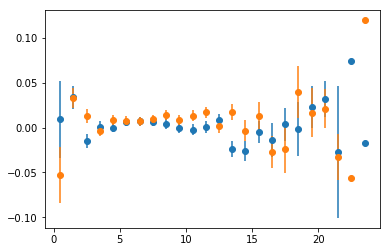

In [94]:
plt.errorbar(bc,b1,db1,marker='o',linestyle='none',label=r'$\Delta\gamma_{1}$')
plt.errorbar(bc,b2,db2,marker='o',linestyle='none',label=r'$\Delta\gamma_{2}$')

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


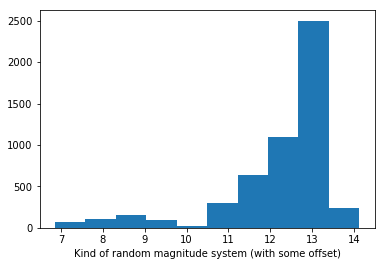

In [91]:
test = -2.5*np.log10(data['psf_flux'])+24
plt.hist(test[np.isnan(test)==False])
plt.xlabel('Kind of random magnitude system (with some offset)')

In [96]:
nan_cut = np.logical_or(np.isnan(test),cut)
bias_mag, dbias_mag, bc =  compute_stats(test[indices],shear_bias[:,0],cut=nan_cut)

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


<Container object of 3 artists>

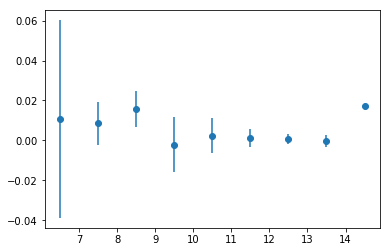

In [97]:
plt.errorbar(bc,bias_mag,dbias_mag,marker='o',linestyle='none')

## Transform any parameters as necessary

### Multiplicative shear bias

### Mean shear

## Plot all the things